# Neural Network Library - Project Demo

CSE473s: Computational Intelligence - Fall 2025

## Overview

This notebook demonstrates a complete neural network library built from scratch using only NumPy.


## Setup and Imports

First, we'll import the necessary libraries and our custom neural network implementation.

In [3]:
# Import required libraries
import numpy as np
import sys
import time
import matplotlib.pyplot as plt
import seaborn as sns

# Add library to path
sys.path.insert(0, '../')

# Import our neural network library
from lib import Network, Dense, ReLU, Sigmoid, Tanh, Softmax, MSE, SGD, plot_losses, plot_decision_boundary, SVM, accuracy_score, confusion_matrix, classification_report, visualize_reconstruction
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, optimizers, losses

## Part 1: XOR Problem Setup

We'll start with the classic XOR dataset, which is a simple binary classification problem that requires a non-linear decision boundary. The inputs are bipolar (-1 or 1) and the target outputs follow the XOR logic.

In [4]:
# XOR dataset
X = np.array([
    [-1,-1],
    [-1,1],
    [1,-1],
    [1,1]
], dtype=float)

y = np.array([
    [-1],
    [1],
    [1],
    [-1]
], dtype=float)

### Training the Custom Neural Network

Now we'll build and train our custom neural network. The architecture consists of:
- Input layer: 2 neurons (for 2D inputs)
- Hidden layer: 4 neurons with Tanh activation
- Output layer: 1 neuron with Tanh activation

We'll use Mean Squared Error (MSE) loss and Stochastic Gradient Descent (SGD) optimizer with a learning rate of 0.5.

In [5]:
model = Network([
    Dense(2, 4),
    Tanh(),
    Dense(4, 1),
    Tanh()
])
loss_fn = MSE()
optimizer = SGD(learning_rate=0.5)

Epoch 0, Loss: 1.000194
Custom NN training time: 0.0688 seconds
✅ Weights saved to weights/xor_model_weights.npz


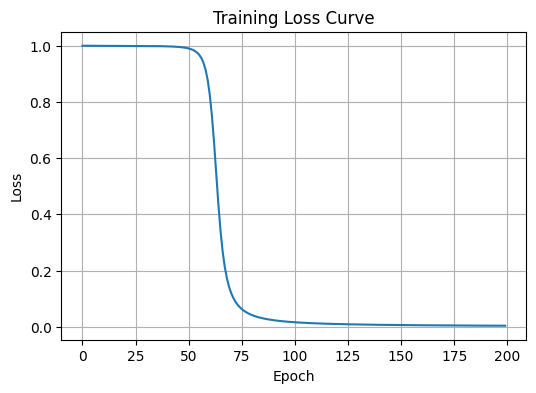

In [6]:
start_custom = time.time()
model.train(X, y, loss_fn, optimizer, epochs=200, verbose=True)
custom_time = time.time() - start_custom
print(f"Custom NN training time: {custom_time:.4f} seconds")
model.save_weights('weights/xor_model_weights.npz')
plot_losses(model.loss_history)


Network Architecture:
Layer 0: Dense | Weights: (2, 4) | Biases: (1, 4)
Layer 1: Tanh
Layer 2: Dense | Weights: (4, 1) | Biases: (1, 1)
Layer 3: Tanh
✅ Weights loaded from weights/xor_model_weights.npz

Final model predictions:
Input (x1,x2)        Target     Predicted    Error     
------------------------------------------------------------
(-1.0, -1.0)         -1.0000    -0.9501      0.0499  ✓
(-1.0, 1.0)          +1.0000    +0.9325      0.0675  ✓
(1.0, -1.0)          +1.0000    +0.9324      0.0676  ✓
(1.0, 1.0)           -1.0000    -0.9499      0.0501  ✓
------------------------------------------------------------

VISUALIZATION: Binary Decision Boundary


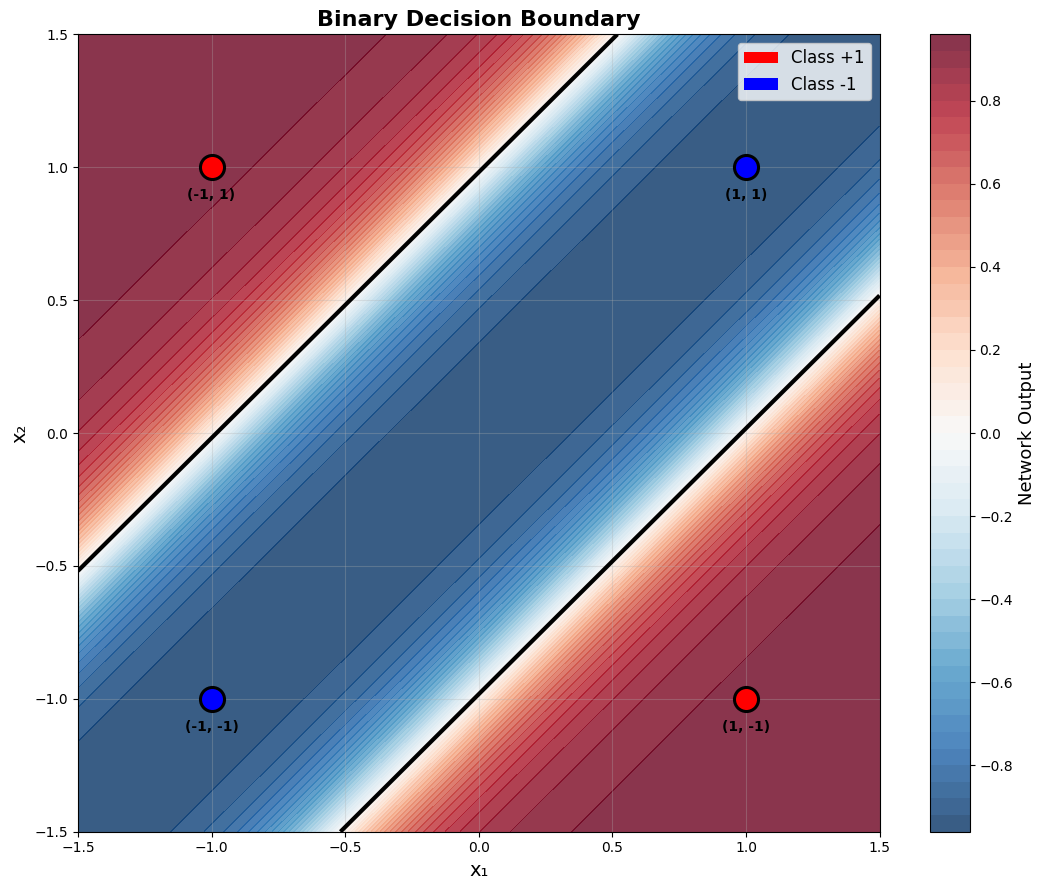

Binary decision boundary visualization complete!


In [7]:
model.summary()
model.load_weights('weights/xor_model_weights.npz')
model.print_final_predictions(X, y)
plot_decision_boundary(model, X, y)

## Part 2: Gradient Checking

We implement a gradient checking function to validate that our backpropagation implementation is correct. This uses numerical differentiation (finite differences) to compare against our analytical gradients for all weight and bias parameters in Dense layers.

In [7]:
def gradient_check(model, X, y, loss_fn, epsilon=1e-5, tol=1e-7):
    """
    Performs gradient checking for all Dense layers in the model.
    
    Arguments:
        model    : Network object
        X, y     : Input and target output
        loss_fn  : Loss class (e.g., MSE)
        epsilon  : Small value for numerical gradient
        tol      : Tolerance for max difference
    """
    # 1. Forward and backward pass to compute analytical gradients
    y_pred = model.forward(X)
    grad_output = loss_fn.grad(y_pred, y)
    model.backward(grad_output)
    
    for idx, layer in enumerate(model.layers):
        if hasattr(layer, 'W'):
            print(f"\n--- Layer {idx} ---")
            
            # ----- Gradient for weights -----
            num_grad_W = np.zeros_like(layer.W)
            for i in range(layer.W.shape[0]):
                for j in range(layer.W.shape[1]):
                    old_val = layer.W[i,j]
                    
                    layer.W[i,j] = old_val + epsilon
                    loss_plus = loss_fn.loss(model.forward(X), y)
                    
                    layer.W[i,j] = old_val - epsilon
                    loss_minus = loss_fn.loss(model.forward(X), y)
                    
                    num_grad_W[i,j] = (loss_plus - loss_minus) / (2*epsilon)
                    layer.W[i,j] = old_val  # reset
            
            max_diff_W = np.max(np.abs(num_grad_W - layer.dW))
            print(f"Max difference in W: {max_diff_W}")
            
            # ----- Gradient for biases -----
            num_grad_b = np.zeros_like(layer.b)
            for i in range(layer.b.shape[1]):
                old_val = layer.b[0,i]
                
                layer.b[0,i] = old_val + epsilon
                loss_plus = loss_fn.loss(model.forward(X), y)
                
                layer.b[0,i] = old_val - epsilon
                loss_minus = loss_fn.loss(model.forward(X), y)
                
                num_grad_b[0,i] = (loss_plus - loss_minus) / (2*epsilon)
                layer.b[0,i] = old_val  # reset
            
            max_diff_b = np.max(np.abs(num_grad_b - layer.db))
            print(f"Max difference in b: {max_diff_b}")
            
            if max_diff_W < tol and max_diff_b < tol:
                print("Gradients match within tolerance.")
            else:
                print("Warning: Gradients may be incorrect.")

gradient_check(model, X, y, loss_fn)



--- Layer 0 ---
Max difference in W: 2.404295512681287e-12
Max difference in b: 5.416672319014104e-12
Gradients match within tolerance.

--- Layer 2 ---
Max difference in W: 2.7932690882526146e-12
Max difference in b: 3.969349154919755e-12
Gradients match within tolerance.


## Part 3: Comparing results with TensorFlow

In [ ]:
# --- 2. TensorFlow model training ---
tf_model = keras.Sequential([
    keras.Input(shape=(2,)),       
    keras.layers.Dense(4, activation='tanh'),
    keras.layers.Dense(1, activation='tanh')
])
tf_model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.5), loss='mean_squared_error')

In [9]:
start_tf = time.time()
tf_model.fit(X, y, epochs=200, verbose=0)
tf_model.save_weights('weights/xor_model_tf_weights.weights.h5')
tf_time = time.time() - start_tf
print(f"TensorFlow training time: {tf_time:.4f} sec")
print(f"Custom model training time: {custom_time:.4f} sec")

TensorFlow training time: 11.3079 sec
Custom model training time: 0.0170 sec


✅ Weights loaded from weights/xor_model_weights.npz
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Final custom model loss: 0.024509
Final TensorFlow model loss: 0.001799

Custom model predictions:
Input: [-1. -1.], Predicted: -0.8275, True: -1.0
Input: [-1.  1.], Predicted: 0.8656, True: 1.0
Input: [ 1. -1.], Predicted: 0.8644, True: 1.0
Input: [1. 1.], Predicted: -0.8216, True: -1.0

TensorFlow model predictions:
Input: [-1. -1.], Predicted: -0.9544, True: -1.0
Input: [-1.  1.], Predicted: 0.9518, True: 1.0
Input: [ 1. -1.], Predicted: 0.9742, True: 1.0
Input: [1. 1.], Predicted: -0.9538, True: -1.0

Max difference between custom model and TensorFlow predictions: 0.132219

VISUALIZATION: Binary Decision Boundary


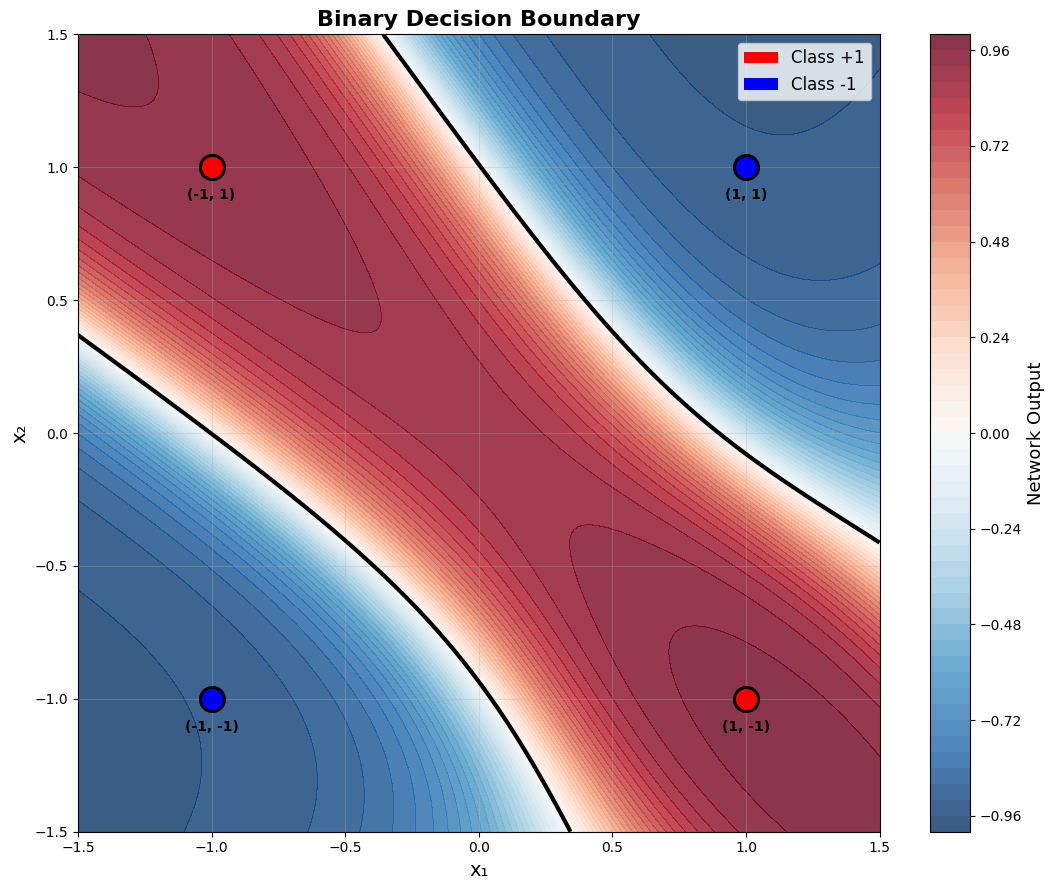

Binary decision boundary visualization complete!


In [10]:
model.load_weights('weights/xor_model_weights.npz')
y_pred = model.forward(X)
final_custom_loss = loss_fn.loss(y_pred, y)

tf_model.load_weights('weights/xor_model_tf_weights.weights.h5')
y_tf_pred = tf_model.predict(X)
final_tf_loss = tf_model.evaluate(X, y, verbose=0)

# --- 3. Compare predictions ---
diff = np.abs(y_pred - y_tf_pred)
max_diff = np.max(diff)

# --- 4. Print results ---
print(f"Final custom model loss: {final_custom_loss:.6f}")
print(f"Final TensorFlow model loss: {final_tf_loss:.6f}")
print("\nCustom model predictions:")
for i in range(len(X)):
    print(f"Input: {X[i]}, Predicted: {y_pred[i][0]:.4f}, True: {y[i][0]}")

print("\nTensorFlow model predictions:")
for i in range(len(X)):
    print(f"Input: {X[i]}, Predicted: {y_tf_pred[i][0]:.4f}, True: {y[i][0]}")

print(f"\nMax difference between custom model and TensorFlow predictions: {max_diff:.6f}")

# --- 5. Plot decision boundary for TensorFlow model ---
plot_decision_boundary(lambda x: tf_model(x).numpy(), X, y)

### **Model Comparison**

| Aspect                | Custom Model       | TensorFlow Model       |
|-----------------------|-----------------|----------------------|
| **Training Time**      | Less | Much more    |
| **Ease of Implementation** | Harder        | Easier            |
| **Flexibility**        | High           | Medium             |
| **Debuggability**      | Easier        | Slightly complex   |
| **Integration**        | Manual         | Built-in functions|


---

### **General Conclusions**

1. **Custom model:**  
   - Full control over architecture and training.  
   - Easier to debug and understand learning behavior.  
   - Requires more manual coding and careful tuning.  

2. **TensorFlow model:**  
   - Fast to implement for standard tasks.  
   - Optimized performance with built-in layers and GPU support.  
   - Less internal control, but easier to scale.

---

### **Effect of Changing Parameters**

| Parameter       | Effect on Model Behavior                                           |
|-----------------|------------------------------------------------------------------|
| **Learning Rate** | Higher → faster convergence but risk of overshooting; Lower → slower but stable |
| **Epochs**        | More → better convergence but may overfit; Fewer → faster but undertrained |
| **Activation Functions** | `tanh` smooths, `relu` faster training, `sigmoid` saturates easily |
| **Hidden Units / Layers** | More → captures complex patterns but risk overfitting; Fewer → simpler and faster |

**Summary:**  

- **Custom model**: Great for learning and experimentation.  
- **TensorFlow model**: Ideal for rapid prototyping and scaling.  
- Hyperparameters (learning rate, epochs, architecture) directly affect convergence and performance.

## Milestone 2: Autoencoder on MNIST

In this section, we will train an **Autoencoder** to compress handwritten digits (MNIST dataset) into a lower-dimensional latent space and then reconstruct them.

**Architecture:**
* **Input:** 784 features (flattened 28x28 images)
* **Encoder:** Compress to 64 latent features (ReLU activation)
* **Decoder:** Reconstruct to 784 features (Sigmoid activation)

In [11]:
# --- Autoencoder on MNIST Dataset ---
# --- Step 1: Data Loading ---
(x_train_raw, y_train), (x_test_raw, y_test) = tf.keras.datasets.mnist.load_data()

# 2. Preprocessing
# Flatten images: (N, 28, 28) -> (N, 784)
X_train = x_train_raw.reshape(x_train_raw.shape[0], -1)
X_test = x_test_raw.reshape(x_test_raw.shape[0], -1)

# Normalize to [0, 1] range (required for Sigmoid output match)
X_train = X_train / 255.0
X_test = X_test / 255.0

# 3. Subsampling for quicker demo
N_SAMPLES = 2000 
N_TEST = 500

X_train_small = X_train[:N_SAMPLES]
y_train_small = y_train[:N_SAMPLES]
X_test_small = X_test[:N_TEST]
y_test_small = y_test[:N_TEST]

print(f"Training Data Shape: {X_train_small.shape}")
print(f"Testing Data Shape: {X_test_small.shape}")

Training Data Shape: (2000, 784)
Testing Data Shape: (500, 784)


### Training the Autoencoder

We define the network using our custom `Network` class. Note that for an autoencoder, the target labels `y` are the same as the input data `X`.

In [ ]:
# 1. Define Architecture
input_dim = 784   # 28x28 pixels
latent_dim = 64   # Bottleneck layer size

layers = [
    # Encoder
    Dense(input_dim, 256),
    ReLU(),
    Dense(256, latent_dim),
    ReLU(),
    # Decoder
    Dense(latent_dim, 256),
    ReLU(),
    Dense(256, input_dim),
    Sigmoid()  
]

# 2. Initialize Network, Loss, and Optimizer
autoencoder = Network(layers)
loss_fn = MSE()
optimizer = SGD(learning_rate=0.1) 

Starting Autoencoder Training...
Epoch 0, Loss: 0.254512
Epoch 500, Loss: 0.022476
Epoch 1000, Loss: 0.014792
Epoch 1500, Loss: 0.011572
Training finished in 7.11 minutes.


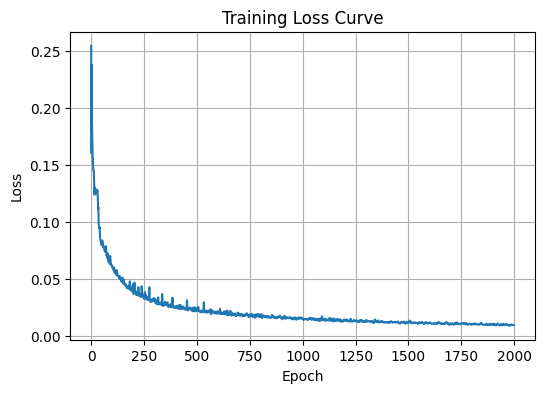

✅ Weights saved to weights/autoencoder_weights.npz


In [14]:
# 3. Train the Network
print("Starting Autoencoder Training...")
start_time = time.time()

# Note: the target 'y' is the same as input 'X'
autoencoder.train(
    X_train_small, 
    X_train_small,  
    loss_fn, 
    optimizer, 
    epochs=2000
)

# 4. Visualize Training Loss
duration = time.time() - start_time
print(f"Training finished in {duration/60:.2f} minutes.")
plot_losses(autoencoder.loss_history)

autoencoder.save_weights('weights/autoencoder_weights.npz')

### Reconstruction Results

We visualize how well the network reconstructs unseen test images. The top row shows the original digits, and the bottom row shows the output from our custom autoencoder.

Reconstruction results on Test Data:


✅ Weights loaded from weights/autoencoder_weights.npz

Network Architecture:
Layer 0: Dense | Weights: (784, 256) | Biases: (1, 256)
Layer 1: ReLU
Layer 2: Dense | Weights: (256, 64) | Biases: (1, 64)
Layer 3: ReLU
Layer 4: Dense | Weights: (64, 256) | Biases: (1, 256)
Layer 5: ReLU
Layer 6: Dense | Weights: (256, 784) | Biases: (1, 784)
Layer 7: Sigmoid


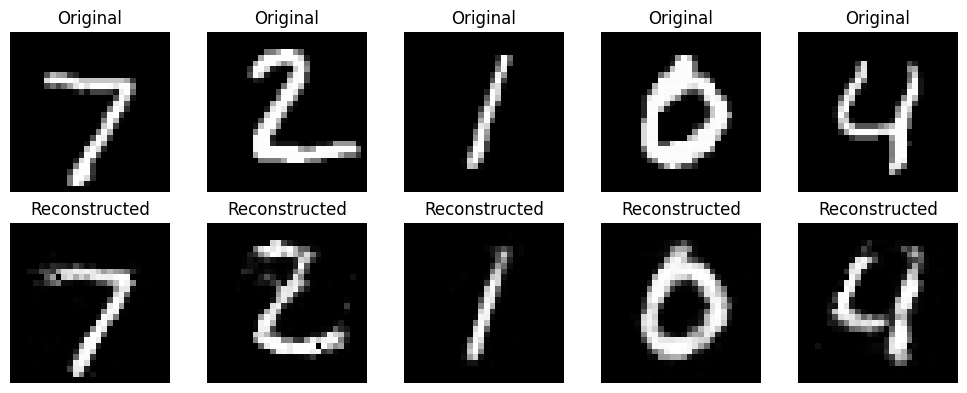

In [15]:
print("Reconstruction results on Test Data:")
autoencoder.load_weights('weights/autoencoder_weights.npz')
autoencoder.summary()
visualize_reconstruction(autoencoder, X_test_small)

## Part 3: Latent Space Classification

Here we demonstrate **Transfer Learning**. We extract the encoder (the first half of the network) to generate compressed 64-dimensional features. We then train a standard SVM classifier on these features to classify the digits.

In [ ]:
# Extract the Encoder
encoder = Network(autoencoder.layers[:4])

print("Extracting features...")

# Generate latent representations (64-dim vectors) for training and test sets
latent_train = encoder.forward(X_train_small)
latent_test = encoder.forward(X_test_small)

print(f"Latent Representation Shape: {latent_train.shape}")

Extracting features...
Latent Representation Shape: (2000, 64)


SVM Accuracy: 85.80%

Classification Report:
Class 0: precision=0.79, recall=0.98, f1-score=0.87, support=42
Class 1: precision=0.97, recall=0.97, f1-score=0.97, support=67
Class 2: precision=0.85, recall=0.84, f1-score=0.84, support=55
Class 3: precision=0.83, recall=0.78, f1-score=0.80, support=45
Class 4: precision=0.88, recall=0.91, f1-score=0.89, support=55
Class 5: precision=0.79, recall=0.74, f1-score=0.76, support=50
Class 6: precision=0.93, recall=0.91, f1-score=0.92, support=43
Class 7: precision=0.83, recall=0.82, f1-score=0.82, support=49
Class 8: precision=0.81, recall=0.72, f1-score=0.76, support=40
Class 9: precision=0.85, recall=0.87, f1-score=0.86, support=54


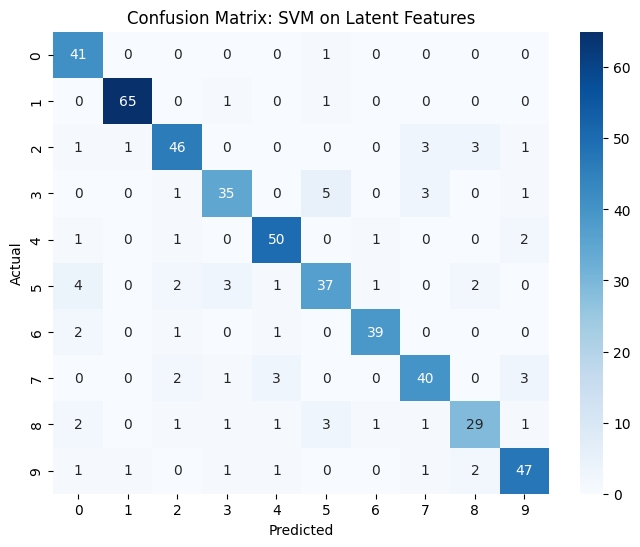

In [17]:
# Train SVM on latent features
svm = SVM(learning_rate=0.0001, lambda_param=0.01, num_epochs=2000, num_classes=10)
svm.fit(latent_train, y_train_small)

# Predictions
y_pred = svm.predict(latent_test)

# Metrics
acc = accuracy_score(y_test_small, y_pred)
print(f"SVM Accuracy: {acc*100:.2f}%")

print("\nClassification Report:")
report = classification_report(y_test_small, y_pred)
for cls, stats in report.items():
    print(f"Class {cls}: precision={stats['precision']:.2f}, recall={stats['recall']:.2f}, f1-score={stats['f1-score']:.2f}, support={stats['support']}")

# Confusion Matrix
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_test_small, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix: SVM on Latent Features')
plt.show()

## Part 4: TensorFlow & Keras Comparison

In this final section, we implement the **exact same autoencoder architecture** using TensorFlow/Keras. This serves as a benchmark to validate our custom library's:
1.  **Correctness:** Do both models converge to a similar loss?
2.  **Performance:** How much faster is the optimized C++ backend of TensorFlow?

In [18]:
# 1. Define the 4-layer autoencoder matching the library
from keras import layers, models, optimizers 

# 1. Define the 4-layer autoencoder matching the library
tf_model = models.Sequential([
    layers.InputLayer(shape=(784,)),
    layers.Dense(256, activation='relu'),  # Encoder Layer 1
    layers.Dense(64, activation='relu'),   # Encoder Layer 2 (latent space)
    layers.Dense(256, activation='relu'),  # Decoder Layer 1
    layers.Dense(784, activation='sigmoid') # Decoder Layer 2 (output)
])


In [19]:
# 2. Compile with same Optimizer and Loss
# Note: specific learning rate to match your custom SGD
sgd = optimizers.SGD(learning_rate=0.5) 
tf_model.compile(optimizer=sgd, loss='mse')

# 3. Train and Measure Time
print("Training TensorFlow Model...")
start_time_tf = time.time()

# We use batch_size=len(X_train_small) to simulate Full-Batch Gradient Descent 
history = tf_model.fit(
    X_train_small, 
    X_train_small, 
    epochs=1000, 
    batch_size=32, 
    verbose=True
)
tf_model.save_weights('weights/autoencoder_model_tf_weights.weights.h5')
tf_duration = time.time() - start_time_tf
tf_final_loss = history.history['loss'][-1]

print(f"TF Training finished in {tf_duration/60:.2f} minutes.")
print(f"TF Final Loss: {tf_final_loss:.6f}")

Training TensorFlow Model...
Epoch 1/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2255
Epoch 2/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.1424
Epoch 3/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0729
Epoch 4/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0702
Epoch 5/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0695
Epoch 6/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0689
Epoch 7/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0686
Epoch 8/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0682
Epoch 9/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0679
Epoch 10/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0676
Epoch 11/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0672
Epoch 12/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0668
Epoch 13/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0664
Epoch 14/1000
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0660
Epoch 15/1000
63/63 ━━━━

### Comparison Results

We compare the reconstruction quality visually and the training metrics numerically.

Visual Comparison of Reconstructions:
✅ Weights loaded from weights/autoencoder_weights.npz


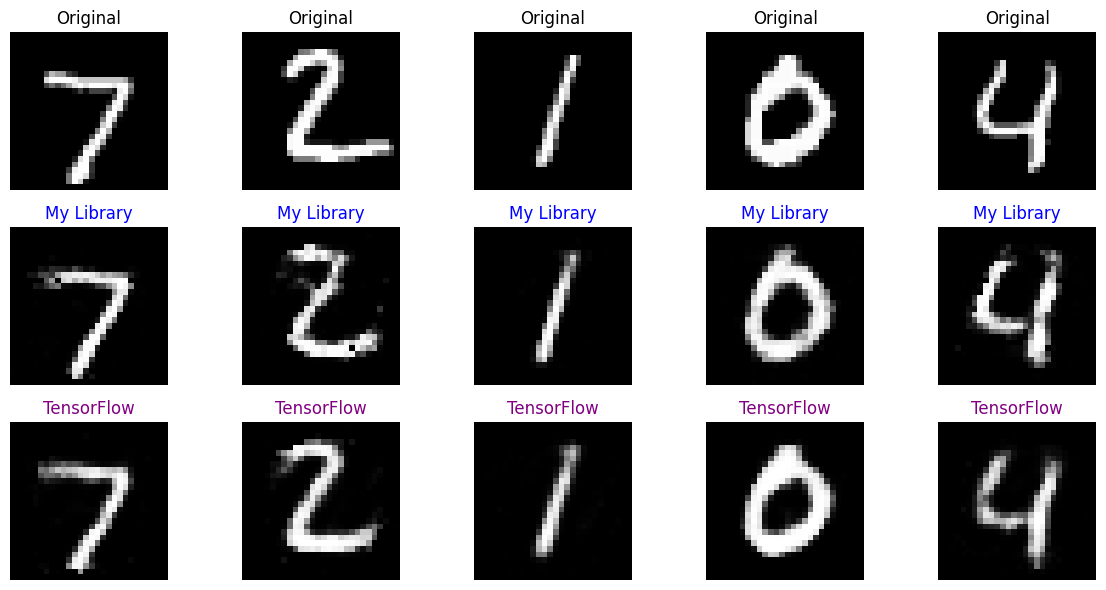

In [20]:
def compare_reconstructions(custom_model, tf_model, X, n=5):
    # Get predictions
    custom_preds = custom_model.forward(X[:n])
    tf_preds = tf_model.predict(X[:n], verbose=0)
    
    plt.figure(figsize=(12, 6))
    for i in range(n):
        # 1. Original
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(X[i].reshape(28, 28), cmap='gray')
        plt.title("Original", fontsize=12)
        plt.axis("off")
        
        # 2. Our Library
        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(custom_preds[i].reshape(28, 28), cmap='gray')
        plt.title("My Library", fontsize=12, color='blue')
        plt.axis("off")

        # 3. TensorFlow
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(tf_preds[i].reshape(28, 28), cmap='gray')
        plt.title("TensorFlow", fontsize=12, color='purple')
        plt.axis("off")
        
    plt.tight_layout()
    plt.show()

print("Visual Comparison of Reconstructions:")
autoencoder.load_weights('weights/autoencoder_weights.npz')
tf_model.load_weights('weights/autoencoder_model_tf_weights.weights.h5')
compare_reconstructions(autoencoder, tf_model, X_test_small)

## Results Comparison

| Metric                  | Custom Library | TensorFlow / Keras |
|--------------------------|----------------|--------------------|
| Final Loss (MSE)         | 0.010757       | 0.007734           |
| Training Time (minutes)  | 7.06           | 4.36               |

---

## Summary
Both implementations successfully trained the autoencoder. TensorFlow/Keras achieved a **lower reconstruction error (MSE)** and trained in **less time** compared to the custom library.

## Conclusion
- **TensorFlow/Keras** is more efficient and accurate, benefiting from highly optimized backend operations.  
- The **custom library** demonstrates the feasibility of building deep learning models from scratch, offering transparency and valuable insight into how autoencoders work.  